0. connect with drive to get all files/directories & load in packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#import libraries for everything
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pathlib
import torch


import data into arrays and make labels from naming of graphs


In [ ]:
# Set memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

tf.keras.backend.clear_session() #clear sesh to make sure no left-overs


In [ ]:
#Load and preprocess images manually
def load_and_preprocess_images(source_dir='/content/drive/MyDrive/EEG/GRAPHS_FORMATTED', img_size=(128,45)):
    files = [f for f in os.listdir(source_dir) if f.lower().endswith('.png')]
    print(f"Found {len(files)} PNG files")
    if len(files) == 0:
        raise ValueError("No PNG files found!")

    images = []
    labels = []
    valid_files = []

    for f in files:
        try:
            # Determine label
            f_upper = f.upper()
            if 'H' in f_upper and 'AD' not in f_upper:
                label = 0  # Healthy
            elif 'AD' in f_upper:
                label = 1  # Alzheimers
            else:
                continue

            # Load and process image
            img_path = os.path.join(source_dir, f)
            img = Image.open(img_path)

            # Resize
            img = img.resize(img_size)

            img_array = np.array(img, dtype=np.float32) / 255.0  # Normalize

            # Verify shape
            if img_array.shape == (img_size[1], img_size[0], 4):
                images.append(img_array)
                labels.append(label)
                valid_files.append(f)
            else:
                print(f"Skipping {f} - unexpected shape: {img_array.shape}")

        except Exception as e:
            print(f"Error processing {f}: {e}")
            continue

    print(f"Successfully loaded {len(images)} images")
    print(f"Healthy: {labels.count(0)}, Alzheimers: {labels.count(1)}")

    if len(images) == 0:
        raise ValueError("No valid images loaded!")

    return np.array(images), np.array(labels), valid_files

# Load images
print("Loading images...")
images, labels, filenames = load_and_preprocess_images()

Loading images...
Found 112 PNG files
Successfully loaded 112 images
Healthy: 42, Alzheimers: 70


In [ ]:
def load_your_dataset():
    # If your data is in numpy format
    X_train = images
    y_train = labels

    return X_train, y_train

# Load your dataset
X_train, y_train = load_your_dataset()

# Print dataset shape to verify
print(f"Input shape: {X_train.shape}")
print(f"Labels shape: {y_train.shape}")

Input shape: (112, 45, 128, 4)
Labels shape: (112,)


In [ ]:
# Determine number of classes
num_classes = len(np.unique(y_train))
print(f"Number of classes: {num_classes}")
input_shape = (128,45,4)
num_classes = 2
model = keras.Sequential()
model.add(keras.layers.Input(shape=input_shape))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(32, (3, 3), padding='same'))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))

        # Second Convolutional Block
model.add(keras.layers.Conv2D(64, (3, 3), padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))

        # Third Convolutional Block
model.add(keras.layers.Conv2D(128, (3, 3), padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))

        # Global pooling
model.add(keras.layers.GlobalAveragePooling2D())

        # Dense layers
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Display model architecture
print("\nModel Summary:")
model.summary()

Number of classes: 2

Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 128, 45, 4)     │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 45, 32)    │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 45, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 22, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 22, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 11, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 11, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 32, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 5, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,498 (626.95 KB)

 Trainable params: 160,106 (625.41 KB)

 Non-trainable params: 392 (1.53 KB)

In [ ]:
# Add callbacks
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
]

# Split data
from sklearn.model_selection import train_test_split
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.3, random_state=42, stratify=y_train
)

print(f"\nData shapes:")
print(f"Training: {X_train_split.shape}, {y_train_split.shape}")
print(f"Validation: {X_val.shape}, {y_val.shape}")



Data shapes:
Training: (78, 45, 128, 4), (78,)
Validation: (34, 45, 128, 4), (34,)


In [ ]:
# Train the model --> fix with dataset size, properly validate
print("\nStarting training...")
history = model.fit(
    X_train_split, y_train_split,
    batch_size=32,
    epochs=25,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)


Starting training...
Epoch 1/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 485ms/step - accuracy: 0.7446 - loss: 0.4745 - val_accuracy: 0.3824 - val_loss: 0.7242
Epoch 2/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 593ms/step - accuracy: 0.6885 - loss: 0.5803 - val_accuracy: 0.3824 - val_loss: 0.7558
Epoch 3/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 374ms/step - accuracy: 0.7791 - loss: 0.4260 - val_accuracy: 0.3824 - val_loss: 0.7793
Epoch 4/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 377ms/step - accuracy: 0.8514 - loss: 0.4150 - val_accuracy: 0.3824 - val_loss: 0.7994
Epoch 5/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 365ms/step - accuracy: 0.8410 - loss: 0.3764 - val_accuracy: 0.3824 - val_loss: 0.8374
Epoch 6/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 353ms/step - accuracy: 0.9007 - loss: 0.3472 - val_accuracy: 0.3824 - val_loss: 0.8979



Validation Accuracy: 0.3824
Validation Loss: 0.7242


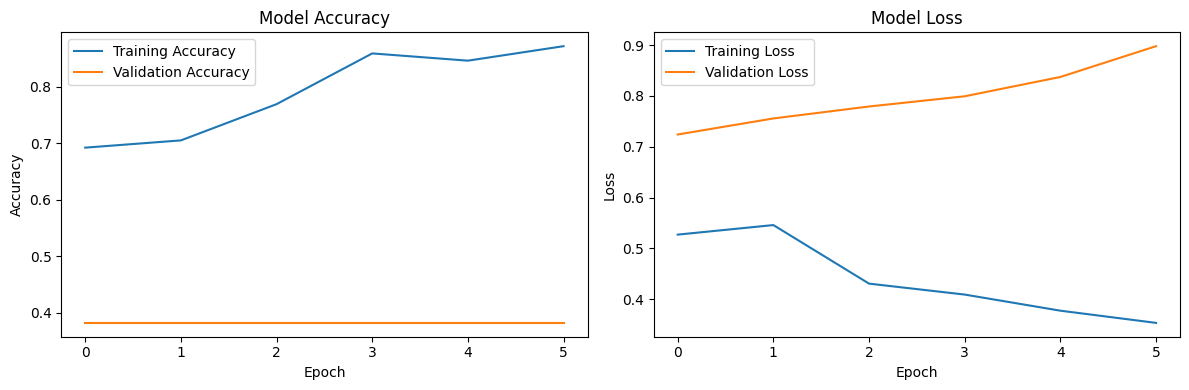

In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"\nValidation Accuracy: {test_accuracy:.4f}")
print(f"Validation Loss: {test_loss:.4f}")

# Plot training history (visual aid helpful + clean later and put into poster if have time to do it)
import matplotlib.pyplot as plt

def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)

In [ ]:
# Save the model
model.save('eeg_graphclassifier.h5')
print("Model saved as 'eeg_graphclassifier.h5'")